<a href="https://colab.research.google.com/github/KALLXCODE/Image-classification-with-ConvMixer/blob/main/4_Image_classification_with_ConvMixer_by_Manoj_Kalyanam_20BAI10031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [4]:
!pip install tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.8 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyperparameters

To keep run time short, we will train the model for only 10 epochs. To focus on
the core ideas of ConvMixer, we will not use other training-specific elements like RandAugment 

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

## Load the CIFAR-10 dataset

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

170498071/170498071 [==============================] - 4s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


## Prepare `tf.data.Dataset` objects

Our data augmentation pipeline is different from what the authors used for the CIFAR-10
dataset, which is fine for the purpose of the example.

In [7]:
image_size = 32
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

## ConvMixer utilities



In [8]:

def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


## Model training and evaluation utility

In [9]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model


## Train and evaluate model

In [10]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 [==============================] - 86s 208ms/step - loss: 1.2172 - accuracy: 0.5616 - val_loss: 4.5496 - val_accuracy: 0.1038
Epoch 2/10
352/352 [==============================] - 73s 208ms/step - loss: 0.7766 - accuracy: 0.7294 - val_loss: 0.7688 - val_accuracy: 0.7290
Epoch 3/10
352/352 [==============================] - 74s 211ms/step - loss: 0.5972 - accuracy: 0.7935 - val_loss: 0.6895 - val_accuracy: 0.7608
Epoch 4/10
352/352 [==============================] - 74s 212ms/step - loss: 0.4860 - accuracy: 0.8302 - val_loss: 0.6173 - val_accuracy: 0.7882
Epoch 5/10
352/352 [==============================] - 75s 212ms/step - loss: 0.4137 - accuracy: 0.8572 - val_loss: 0.5871 - val_accuracy: 0.7978
Epoch 6/10
352/352 [==============================] - 75s 213ms/step - loss: 0.3468 - accuracy: 0.8815 - val_loss: 0.5240 - val_accuracy: 0.8170
Epoch 7/10
352/352 [==============================] - 75s 212ms/step - loss: 0.3029 - accuracy: 0.8950 - val_loss: 0.5091 - val_ac

## Visualizing the internals of ConvMixer



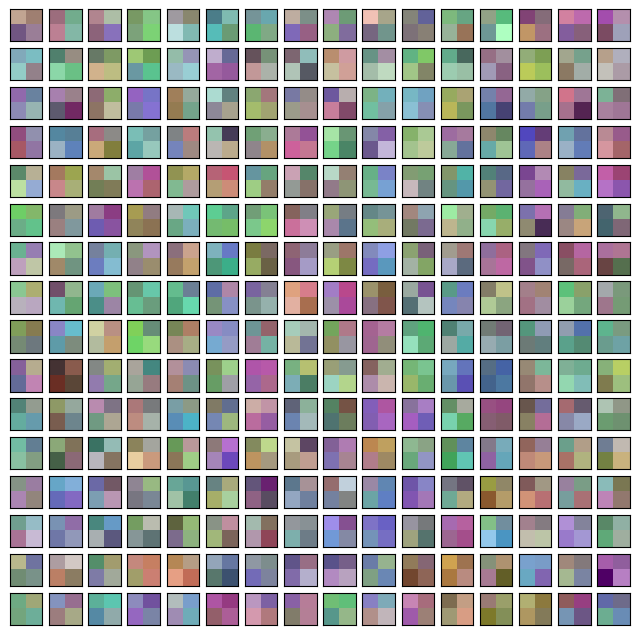

In [11]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

5 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f2690581c70>
12 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f26904fa400>
19 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f2690509dc0>
26 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f269051cb20>
33 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f26904db9a0>
40 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f2690526d90>
47 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f26904715b0>
54 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f2690480490>


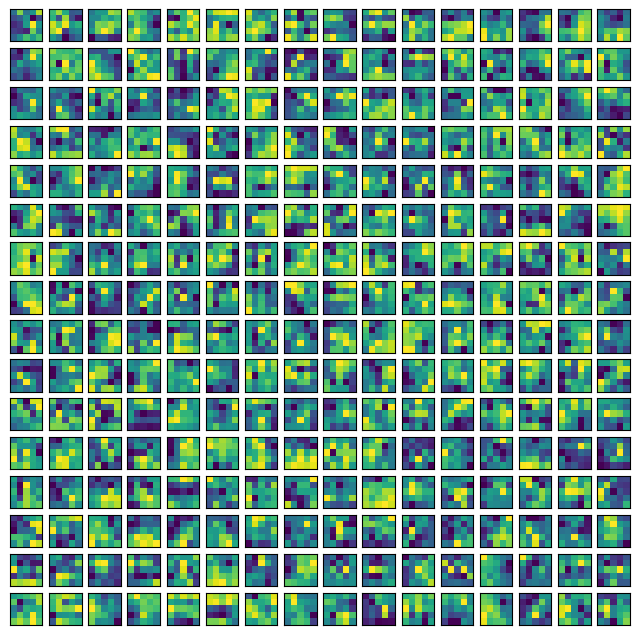

In [12]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

We see that different filters in the kernel have different locality spans, and this pattern
is likely to evolve with more training.